# **DOMAIN´S CLUSTERING**

- In this notebook I´m going to try and test different clustering models, preprocessing the data in different ways to compare and choose the best results, that is, to find different clusters with similar charasteristics or properties, with the objective of make the advertiser decision of where are the optimal domains to invest easier

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns
import pickle
from sklearn.cluster import KMeans, OPTICS, AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics.pairwise import manhattan_distances


from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, QuantileTransformer

from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score, davies_bouldin_score

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

pd.options.display.float_format = '{:.2f}'.format #So the numbers will not appear in a scientific format

#! pip install pyclustertend

In [4]:
groupby_domains = pd.read_csv('DATA/Global groupby_domains.csv')

### IMPORTANT: 
**The proccess that is detailed below has been done with different combinations of variables**.

- First I considered all the variables at once, applying different data preproccesings 
- Second I tested the clustering algorithms several times selecting different combinations of variables, between 6 and 9
- Finally I did that comes next, wich has turned out to be the best choice

****In order to get a better clustering performance, I´m gonna drop the following columns :****

- **Domain:** it´s a string and doesn´t add nothing to the model
- **Category:** I could convert the Categories into numbers, but this can strongly affect to the model, and the categories are also represented in the Category importance columns
- **Viewability Rate, Efficiency Rate:** these columns are important to the advertisers (that´s the reason I didn´t drop them in the first place) but both of them have really high percentages for most of Domains, so they are not useful to find differences between them
- **Clicks**: It has a strong correlation with the Impressions variable, and it´s represented in the CTR (Clicks/Impressions)

- **'Format Loads', 'Impressions'**: ***After repeating this whole proccess with different variables, I decided to keep for this clustering only the variables represented by percentages, in order to have the date with similar scales. It has proven that if I take the Format Loads and Impressions variable, the models are distorted because of it´s large scale, although I applied transformation to the data as MinMax, Standard or Robust scalers***

In [5]:
groupby_domains_clustering = groupby_domains.drop(['Domain','Format Loads', 'Impressions', 'Clicks','Category',
                                                   'Viewability Rate', 'Efficiency Rate'], 1)

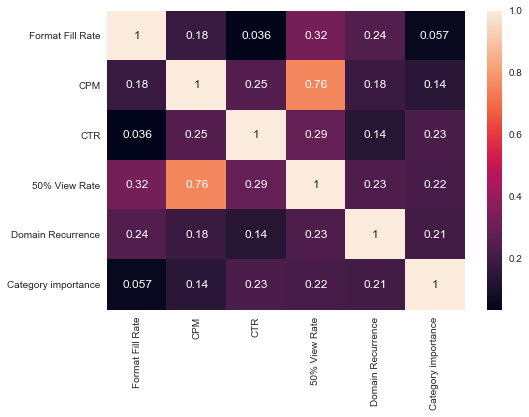

In [91]:
sns.heatmap(groupby_domains_clustering.corr(), annot=True)

(array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000177FF2543C8>,
       dtype=object),)

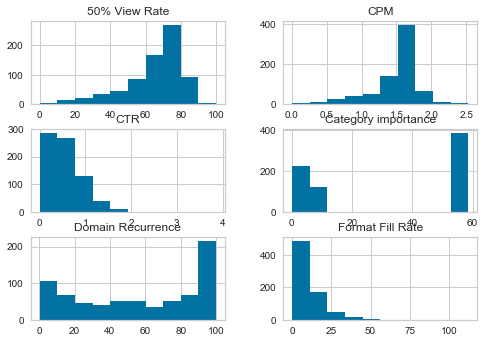

In [10]:
groupby_domains_clustering.hist(),

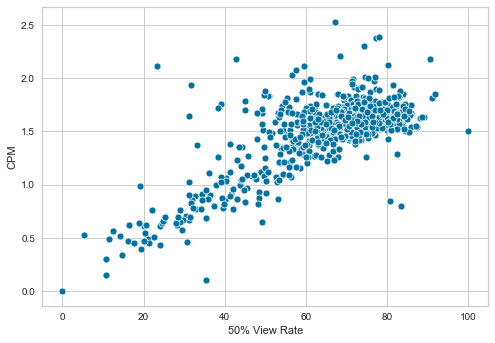

In [11]:
sns.scatterplot(groupby_domains_clustering['50% View Rate'], groupby_domains_clustering['CPM'])

**We see that the variables 50% View Rate and CPM have a strong correlation. It is not recommended to train clustering algorithms with correlated vatriables. I´ll drop 50% View Rate, I consider the CPM variable more important**

In [6]:
groupby_domains_clustering.drop('50% View Rate', 1, inplace = True)

I´m gonna test the clustering over three different data transformations :

- **Standarizing the data with Standard Scaler**
- **Scaling features using statistics that are robust to outliers with Robust Scaler**
- **Transforming features by scaling each feature to a given range (0,1) with MinMax Scaler**

In [7]:
groupby_domains_StandardScaler = StandardScaler().fit_transform(groupby_domains_clustering)
groupby_domains_RobustScaler = RobustScaler().fit_transform(groupby_domains_clustering)
minmax = MinMaxScaler().fit_transform(groupby_domains_clustering)

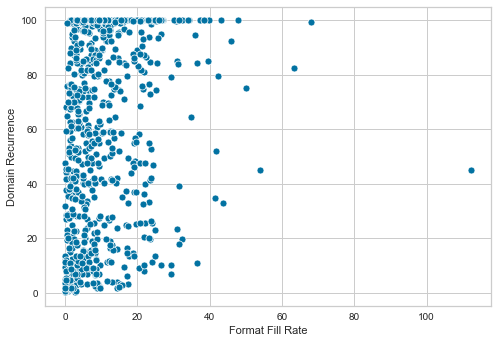

In [95]:
sns.scatterplot(groupby_domains_clustering['Format Fill Rate'], groupby_domains_clustering['Domain Recurrence'])

### Visual Assessment of cluster Tendency (VAT)

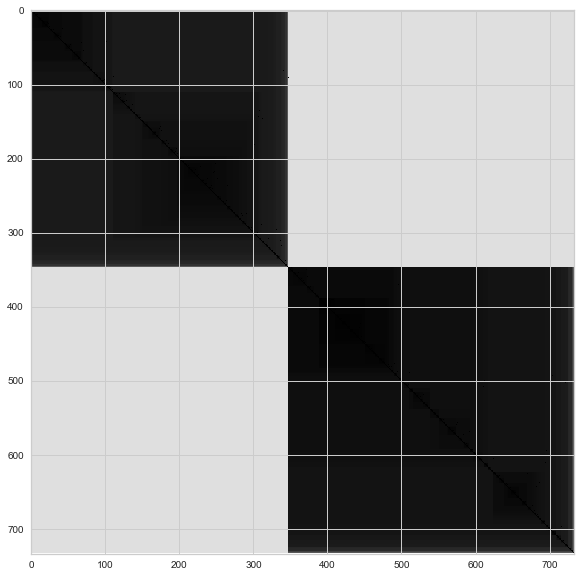

In [96]:
from pyclustertend import ivat
ivat(groupby_domains_clustering)

## Applying GRIDSEARCHCV to find the best parameters for KMEANS ALGORITHM (THIS SECTION HAS TO BE UPDATED WITH THE LATEST VERSION OF THE DATA)

- ### With the Standard Scaler transformation:

In [8]:
kmeans = KMeans()
parameters = {'n_clusters':range(1,15),
              'init' : ('k-means++', 'random'), 
              'n_init':[5,10,15,20,25],
              'max_iter' : [50,100,200,300,400,500,700,1000],
              'algorithm' : ('auto', 'full', 'elkan')}

gridsearchcv_standardscaler = GridSearchCV(estimator = kmeans, param_grid = parameters)

In [10]:
%%time
gridsearchcv_standardscaler.fit(groupby_domains_StandardScaler)

Wall time: 42min 47s


GridSearchCV(cv=None, error_score=nan,
             estimator=KMeans(algorithm='auto', copy_x=True, init='k-means++',
                              max_iter=300, n_clusters=8, n_init=10,
                              n_jobs=None, precompute_distances='auto',
                              random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'algorithm': ('auto', 'full', 'elkan'),
                         'init': ('k-means++', 'random'),
                         'max_iter': [50, 100, 200, 300, 400, 500, 700, 1000],
                         'n_clusters': range(1, 15),
                         'n_init': [5, 10, 15, 20, 25]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [12]:
#Saving the results in a DataFrame
gridsearch_results_SS = pd.DataFrame(gridsearchcv_standardscaler.cv_results_).sort_values(by='rank_test_score')
gridsearch_results_SS.to_csv('GridSearch Standard Scaler Results.csv')
gridsearch_results_SS.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_init,param_max_iter,param_n_clusters,param_n_init,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3145,0.04,0.00,0.00,0.00,elkan,random,400,14,5,"{'algorithm': 'elkan', 'init': 'random', 'max_...",-1817.66,-527.36,-547.53,-402.67,-441.44,-747.33,537.82,1
1815,0.08,0.01,0.00,0.00,full,random,100,14,5,"{'algorithm': 'full', 'init': 'random', 'max_i...",-2077.53,-493.75,-527.52,-408.41,-485.67,-798.58,640.67,2
3146,0.10,0.00,0.00,0.00,elkan,random,400,14,10,"{'algorithm': 'elkan', 'init': 'random', 'max_...",-2102.65,-454.43,-534.86,-390.99,-510.29,-798.64,653.88,3


In [13]:
# save the model to disk
filename = 'gridsearchmodel_standardscaler.sav'
pickle.dump(gridsearchcv_standardscaler, open(filename, 'wb'))

In [14]:
# load the model from disk
filename = 'gridsearchmodel_standardscaler.sav'
gridsearchmodel_standardscaler = pickle.load(open(filename, 'rb'))


In [15]:
gridsearchmodel_standardscaler.best_estimator_

KMeans(algorithm='elkan', copy_x=True, init='random', max_iter=400,
       n_clusters=14, n_init=5, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

- ### With the Robust Scaler transformation:

In [16]:
kmeans = KMeans()
parameters = {'n_clusters':range(1,17),
              'init' : ('k-means++', 'random'), 
              'n_init':[5,10,15,20,25],
              'max_iter' : [50,100,200,300,400,700,1000],
              'algorithm' : ('auto', 'full', 'elkan')}

gridsearchcv_robustscaler = GridSearchCV(estimator = kmeans, param_grid = parameters)

In [17]:
%%time
gridsearchcv_robustscaler.fit(groupby_domains_RobustScaler)

Wall time: 51min 34s


GridSearchCV(cv=None, error_score=nan,
             estimator=KMeans(algorithm='auto', copy_x=True, init='k-means++',
                              max_iter=300, n_clusters=8, n_init=10,
                              n_jobs=None, precompute_distances='auto',
                              random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'algorithm': ('auto', 'full', 'elkan'),
                         'init': ('k-means++', 'random'),
                         'max_iter': [50, 100, 200, 300, 400, 700, 1000],
                         'n_clusters': range(1, 17),
                         'n_init': [5, 10, 15, 20, 25]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [19]:
#Saving the results in a DataFrame
gridsearch_results_RS = pd.DataFrame(gridsearchcv_robustscaler.cv_results_).sort_values(by='rank_test_score')
gridsearch_results_RS.to_csv('GridSearch Results with Robust Scaler.csv')
gridsearch_results_RS.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_init,param_max_iter,param_n_clusters,param_n_init,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3356,0.12,0.02,0.00,0.00,elkan,random,1000,16,10,"{'algorithm': 'elkan', 'init': 'random', 'max_...",-5372.63,-686.85,-633.02,-462.59,-555.98,-1542.21,1916.70,1
2956,0.19,0.02,0.00,0.00,elkan,random,100,16,10,"{'algorithm': 'elkan', 'init': 'random', 'max_...",-5341.84,-697.44,-665.97,-512.00,-543.19,-1552.09,1896.18,2
1039,0.38,0.04,0.00,0.00,auto,random,700,16,25,"{'algorithm': 'auto', 'init': 'random', 'max_i...",-5346.14,-675.65,-684.13,-519.91,-557.82,-1556.73,1895.79,3


In [20]:
# save the model to disk
filename = 'gridsearchmodel_robustscaler.sav'
pickle.dump(gridsearchcv_robustscaler, open(filename, 'wb'))

In [21]:
# load the model from disk
filename = 'gridsearchmodel_robustscaler.sav'
gridsearchmodel_robustscaler = pickle.load(open(filename, 'rb'))


In [22]:
gridsearchmodel_robustscaler.best_estimator_

KMeans(algorithm='elkan', copy_x=True, init='random', max_iter=1000,
       n_clusters=16, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

- ### With the MinMax Scaler transformation:

In [16]:
kmeans = KMeans()
parameters = {'n_clusters':range(1,17),
              'init' : ('k-means++', 'random'), 
              'n_init':[5,10,15,20,25],
              'max_iter' : [50,100,200,300,400,700,1000],
              'algorithm' : ('auto', 'full', 'elkan')}

gridsearchcv_robustscaler = GridSearchCV(estimator = kmeans, param_grid = parameters)

In [17]:
%%time
gridsearchcv_minmax.fit(minmax)

Wall time: 51min 34s


GridSearchCV(cv=None, error_score=nan,
             estimator=KMeans(algorithm='auto', copy_x=True, init='k-means++',
                              max_iter=300, n_clusters=8, n_init=10,
                              n_jobs=None, precompute_distances='auto',
                              random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'algorithm': ('auto', 'full', 'elkan'),
                         'init': ('k-means++', 'random'),
                         'max_iter': [50, 100, 200, 300, 400, 700, 1000],
                         'n_clusters': range(1, 17),
                         'n_init': [5, 10, 15, 20, 25]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [19]:
#Saving the results in a DataFrame
gridsearch_results_MM = pd.DataFrame(gridsearchcv_minmax.cv_results_).sort_values(by='rank_test_score')
gridsearch_results_MM.to_csv('GridSearch Results with MinMax Scaler.csv')
gridsearch_results_MM.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_init,param_max_iter,param_n_clusters,param_n_init,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3356,0.12,0.02,0.00,0.00,elkan,random,1000,16,10,"{'algorithm': 'elkan', 'init': 'random', 'max_...",-5372.63,-686.85,-633.02,-462.59,-555.98,-1542.21,1916.70,1
2956,0.19,0.02,0.00,0.00,elkan,random,100,16,10,"{'algorithm': 'elkan', 'init': 'random', 'max_...",-5341.84,-697.44,-665.97,-512.00,-543.19,-1552.09,1896.18,2
1039,0.38,0.04,0.00,0.00,auto,random,700,16,25,"{'algorithm': 'auto', 'init': 'random', 'max_i...",-5346.14,-675.65,-684.13,-519.91,-557.82,-1556.73,1895.79,3


In [20]:
# save the model to disk
filename = 'gridsearchmodel_robustscaler.sav'
pickle.dump(gridsearchcv_robustscaler, open(filename, 'wb'))

In [21]:
# load the model from disk
filename = 'gridsearchmodel_robustscaler.sav'
gridsearchmodel_robustscaler = pickle.load(open(filename, 'rb'))


In [22]:
gridsearchmodel_robustscaler.best_estimator_

KMeans(algorithm='elkan', copy_x=True, init='random', max_iter=1000,
       n_clusters=16, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

**I decide not to choose the random init, although it has been chosen as the best init parameter in both scenarios. In some cases, if the initialization of clusters is not appropriate, K-Means can result in arbitrarily bad clusters. This is where K-Means++ helps, because it specifies a procedure to initialize the cluster centers before moving forward with the standard k-means clustering algorithm**

**Using the K-Means++ algorithm, we optimize the step where we randomly pick the cluster centroid, and we are more likely to find a solution that is competitive to the optimal K-Means solution while using the K-Means++ initialization**

Because of that, I´ll choose the best result where with the k-means++ init:

In [19]:
gridsearch_results_RS = pd.read_csv("GridSearch Results with Robust Scaler.csv")
gridsearch_results_SS = pd.read_csv("GridSearch Standard Scaler Results.csv")
display(gridsearch_results_RS[gridsearch_results_RS['param_init']=='k-means++'].head(1))
display(gridsearch_results_RS[gridsearch_results_SS['param_init']=='k-means++'].head(1))

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_init,param_max_iter,param_n_clusters,param_n_init,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,556,0.16,0.01,0.00,0.00,auto,k-means++,1000,16,10,"{'algorithm': 'auto', 'init': 'k-means++', 'ma...",-5363.48,-682.62,-667.99,-592.56,-580.18,-1577.37,1893.49,10


,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_init,param_max_iter,param_n_clusters,param_n_init,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,3350,0.06,0.00,0.00,0.00,elkan,random,1000,15,5,"{'algorithm': 'elkan', 'init': 'random', 'max_...",-5381.67,-690.97,-703.62,-508.84,-577.82,-1572.59,1905.92,8


# KMEANS ALGORITHM

### ELBOW METHOD visualization to check the ideal number of clusters 

In [8]:
def visualization_clusters(data, clustering_model):

    # calinski_harabasz and silhouette scores visualization
    visualizer1 = KElbowVisualizer(
        clustering_model, k=(3,17), metric='calinski_harabasz', timings=False
    )

    visualizer1.fit(data)        # Fit the data to the visualizer
    visualizer1.show()        # Finalize and render the figure

    visualizer2 = KElbowVisualizer(
        clustering_model, k=(3,17), metric='silhouette', timings=False
    )

    visualizer2.fit(data)        # Fit the data to the visualizer
    visualizer2.show()        # Finalize and render the figure
    
    visualizer3 = KElbowVisualizer(
    clustering_model, k=(3,17), metric='distortion', timings=False
    )

    visualizer3.fit(data)        # Fit the data to the visualizer
    visualizer3.show()        # Finalize and render the figure

- ### With the Standard Scaler transformation:

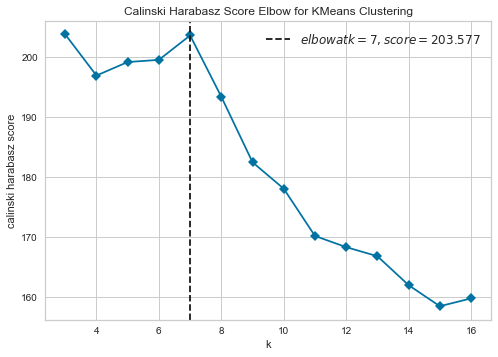

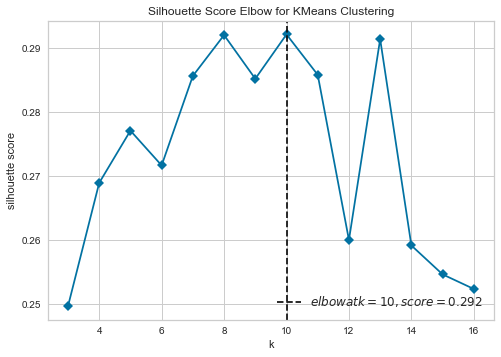

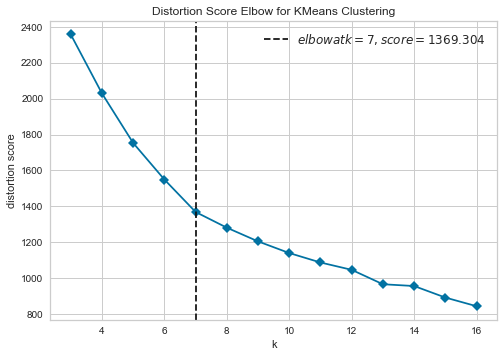

In [98]:
model = KMeans(init='k-means++', max_iter=1000, n_init=5, algorithm='elkan')
visualization_clusters(groupby_domains_StandardScaler, model)

- ### With the Robust Scaler transformation:

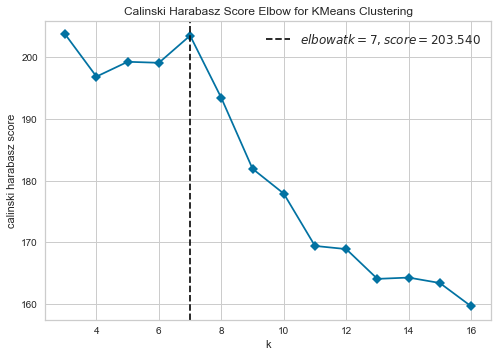

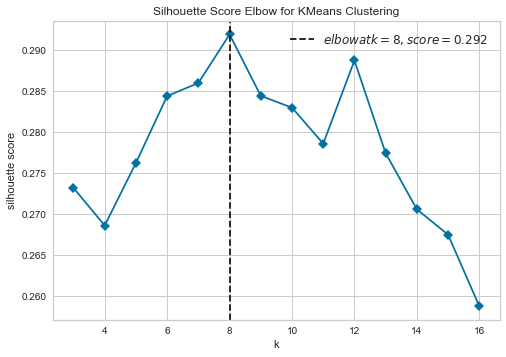

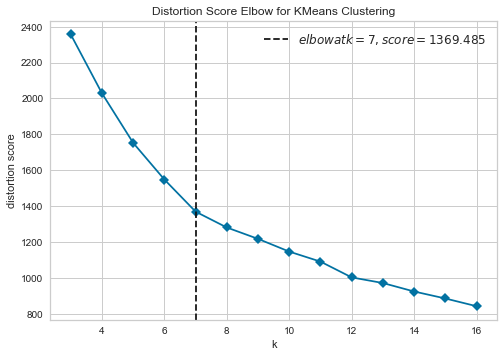

In [99]:
model = KMeans(init='k-means++', max_iter=1000, n_init=5, algorithm='auto')
visualization_clusters(groupby_domains_StandardScaler, model)

- ### With the MinMax transformation:

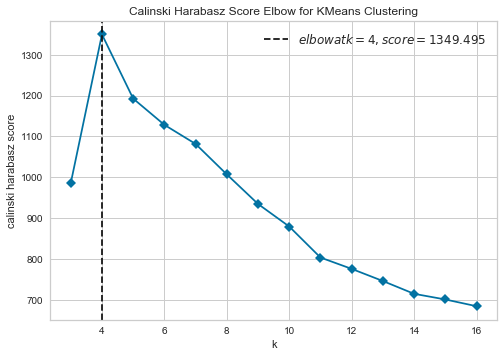

C:\Users\Usuario\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\Usuario\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\Usuario\anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


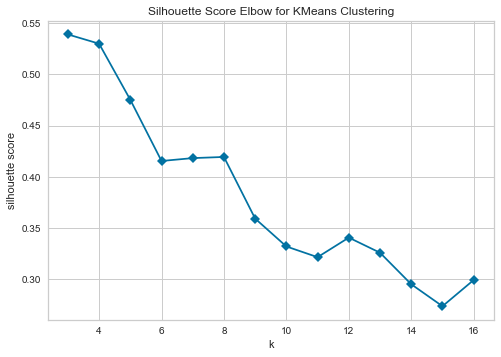

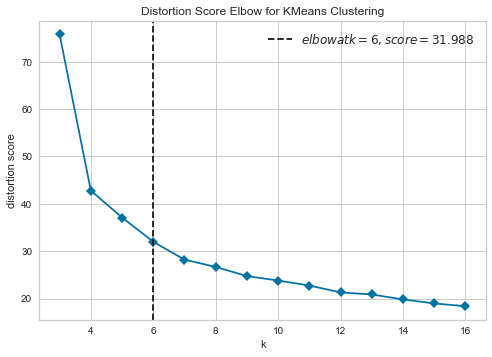

In [100]:
model = KMeans(init='k-means++', max_iter=1000, n_init=5, algorithm='elkan')
visualization_clusters(minmax, model)

- ### With the raw Data :

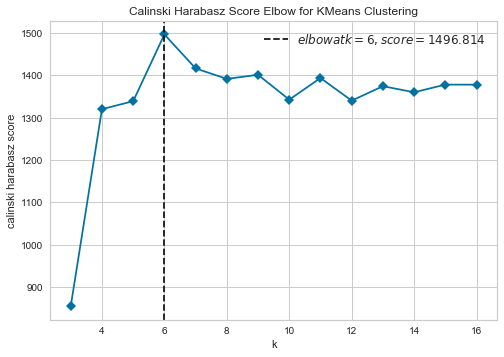

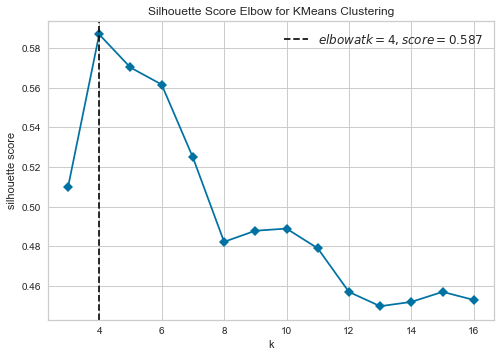

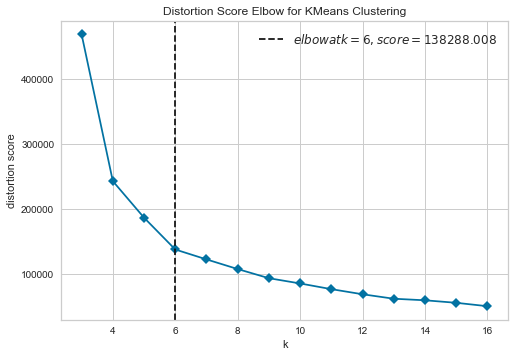

In [20]:
model = KMeans(init='k-means++', max_iter=1000, n_init=5, algorithm='elkan')
visualization_clusters(groupby_domains_clustering, model)

- **My first impression is that, in order to simplify and make the advertiser decision easier, detecting a specific cluster attending to its preferences, the number of clusters should not be more than 10**

- **The GridSearchCV best result for n_clusters is the maximum I defined (14 in the first case, and 16 in the second case). But attending to the Elbow Method I´m gonna train the Kmeans Model with 9 clusters**

### Training the KMEANS model

In [9]:
def results_evaluation(model, data):

    #This function has 2 arguments:
    #-model: to define de Clusters and the scores
    #-data: the data I´m working with, to calculate the scores
  

    print('CLUSTERING DIVISION:\n', pd.DataFrame(model.labels_)[0].value_counts())
    
    new_df = groupby_domains.copy()
    new_df['Cluster'] = model.labels_
    display(new_df.groupby('Cluster').mean())
    
    print('The Silhouette Score is: ', silhouette_score(data, model.labels_, metric='euclidean'))
    print('The Calinski Harabasz Score is: ', calinski_harabasz_score(data, model.labels_))
    print('The Davies Douldin Score is: ', davies_bouldin_score(data, model.labels_))


- ### With the optimal parameters for Standard Scaled Data, based on the GridSearchCV results

In [102]:
kmeans_StandardScaler = KMeans(n_clusters=7, init='k-means++', max_iter=1000, n_init=5, algorithm='elkan')
kmeans_StandardScaler.fit(groupby_domains_StandardScaler)
results_evaluation(kmeans_StandardScaler, groupby_domains_StandardScaler)


CLUSTERING DIVISION:
 2    178
6    134
3    128
0    108
1     79
5     65
4     42
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Domain Recurrence,Category importance
Cluster,,,,,,,,,,,
0,166504.56,7850.44,7.37,78.12,85.88,1.58,39.83,0.48,68.85,30.41,58.61
1,96145.81,5305.53,4.01,35.80,42.36,0.71,30.76,0.23,32.21,36.48,22.68
2,147463.76,13491.40,10.11,79.19,91.54,1.61,87.03,0.62,71.88,89.50,58.61
3,163291.13,7585.87,6.59,75.78,86.59,1.60,30.49,0.38,65.69,16.45,4.19
4,153277.80,49438.94,38.99,78.35,93.33,1.65,197.45,0.41,75.53,76.95,35.61
5,152265.79,16300.16,9.60,84.61,91.80,1.60,211.28,1.35,70.86,51.43,46.10
6,121161.81,10804.65,10.49,74.49,89.65,1.56,59.56,0.54,67.47,87.50,4.13


The Silhouette Score is:  0.2855799619838076
The Calinski Harabasz Score is:  203.5833629668298
The Davies Douldin Score is:  1.126862298063587


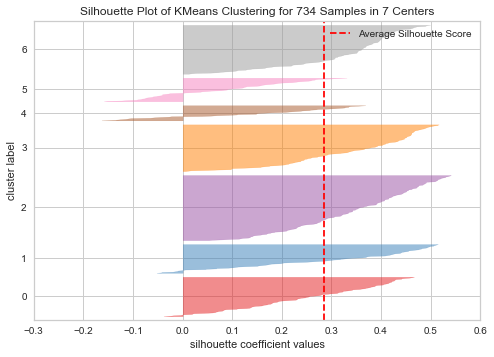

In [103]:
sv = SilhouetteVisualizer(kmeans_StandardScaler)
sv.fit(groupby_domains_StandardScaler)
sv.show()

- ### With the optimal parameters for Robust Scaled Data, based on the GridSearchCV results

In [108]:
kmeans_RobustScaler = KMeans(n_clusters=7, init='k-means++', max_iter=1000, n_init=5, algorithm='auto')
kmeans_RobustScaler.fit(groupby_domains_RobustScaler)
results_evaluation(kmeans_RobustScaler, groupby_domains_RobustScaler)


CLUSTERING DIVISION:
 6    178
3    144
1    121
0    104
2     82
5     71
4     34
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Domain Recurrence,Category importance
Cluster,,,,,,,,,,,
0,143420.81,13002.28,8.32,83.26,92.49,1.60,160.71,1.22,69.38,61.42,37.78
1,136723.44,21489.06,20.13,80.05,94.33,1.61,119.28,0.55,73.75,75.02,33.62
2,96239.83,5704.86,4.65,35.86,42.74,0.72,33.45,0.24,32.54,39.42,23.27
3,113337.06,6087.73,6.45,69.54,79.26,1.36,33.87,0.43,61.94,44.33,26.40
4,161878.53,55337.94,41.48,78.93,93.14,1.66,216.54,0.39,76.13,72.32,34.73
5,143993.04,6430.81,4.68,75.63,88.83,1.85,13.67,0.22,66.31,26.57,13.68
6,190447.04,8922.98,6.01,81.35,92.55,1.66,50.74,0.58,72.91,73.46,46.49


The Silhouette Score is:  0.21043231475202792
The Calinski Harabasz Score is:  242.69776750747974
The Davies Douldin Score is:  1.3082171472641595


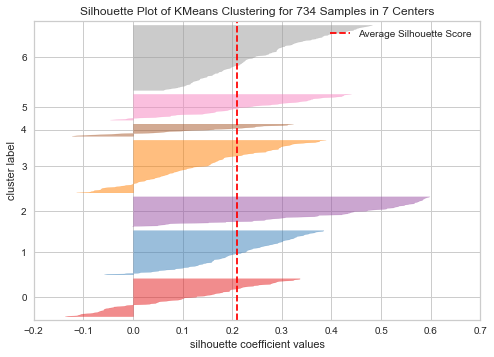

In [109]:
sv = SilhouetteVisualizer(kmeans_RobustScaler)
sv.fit(groupby_domains_RobustScaler)
sv.show()

- ### With the MinMax transformation

In [119]:
kmeans_minmax = KMeans(n_clusters=4, init='k-means++', max_iter=1000, n_init=5, algorithm='elkan')
kmeans_minmax.fit(minmax)
results_evaluation(kmeans_minmax, minmax)


CLUSTERING DIVISION:
 2    224
3    190
0    163
1    157
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Domain Recurrence,Category importance
Cluster,,,,,,,,,,,
0,158281.56,10556.18,9.16,75.43,82.35,1.49,71.26,0.62,66.20,30.81,58.61
1,124613.31,15471.54,12.17,72.65,87.89,1.53,76.95,0.53,66.30,87.89,4.30
2,147406.59,15838.06,11.75,77.79,89.88,1.58,109.58,0.65,70.54,89.61,58.61
3,141658.90,8030.52,7.32,66.87,76.55,1.38,41.53,0.40,57.91,19.00,4.10


The Silhouette Score is:  0.5298067909938917
The Calinski Harabasz Score is:  1349.4946286227978
The Davies Douldin Score is:  0.69387443684149


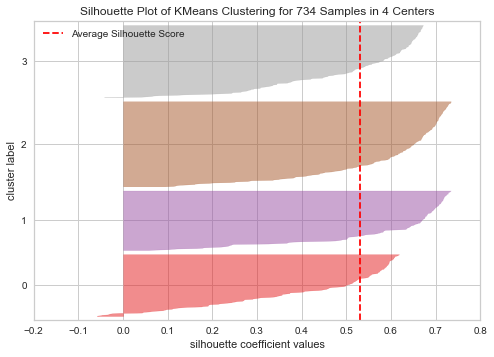

In [120]:
sv = SilhouetteVisualizer(kmeans_minmax)
sv.fit(minmax)
sv.show()

- ### With the raw data

In [123]:
kmeans_raw = KMeans(n_clusters=4, init='k-means++', max_iter=1000, n_init=5, algorithm='elkan')
kmeans_raw.fit(groupby_domains_clustering)
results_evaluation(kmeans_raw, groupby_domains_clustering)


CLUSTERING DIVISION:
 1    225
0    192
2    162
3    155
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Domain Recurrence,Category importance
Cluster,,,,,,,,,,,
0,140876.26,8022.02,7.37,67.03,76.73,1.39,41.73,0.41,58.01,19.35,4.11
1,146895.67,15776.97,11.70,77.54,89.59,1.57,109.15,0.65,70.31,89.48,58.61
2,159058.31,10608.42,9.20,75.77,82.70,1.50,71.63,0.62,66.49,30.62,58.61
3,125362.84,15578.08,12.17,72.53,87.81,1.52,77.16,0.53,66.27,88.34,4.29


The Silhouette Score is:  0.5869855723314092
The Calinski Harabasz Score is:  1320.2311051374973
The Davies Douldin Score is:  0.5979740924195207


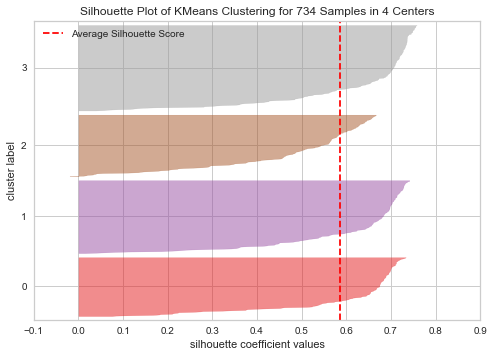

In [122]:
sv = SilhouetteVisualizer(kmeans_raw)
sv.fit(groupby_domains_clustering)
sv.show()

## HIERARCHICAL CLUSTERING

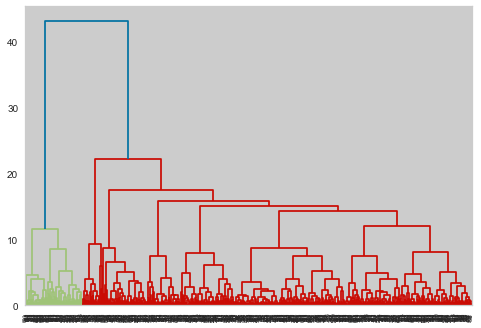

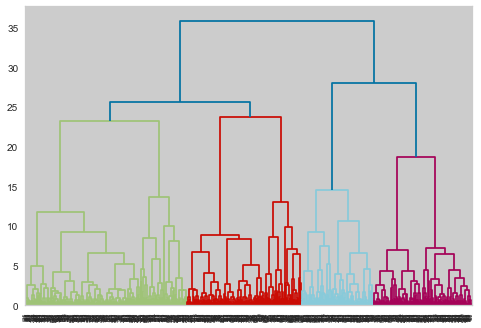

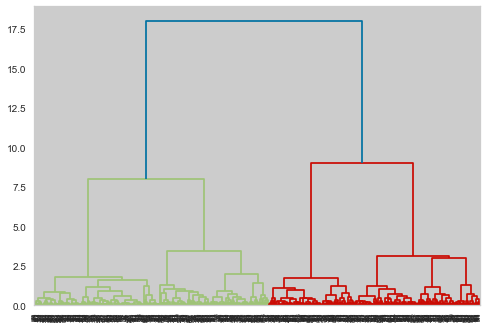

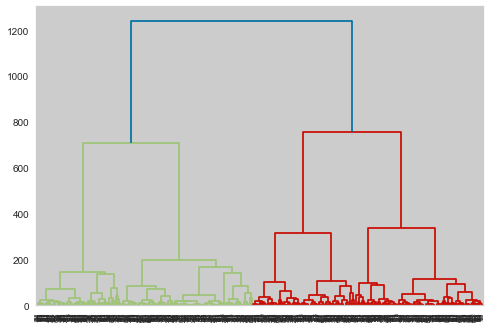

In [124]:
for data in [groupby_domains_RobustScaler,groupby_domains_StandardScaler,minmax, groupby_domains_clustering]:
    Z = linkage(data, 'ward') #'single', 'ward', ...
    dendrogram(Z)
    plt.show()

- ### ROBUSTSCALER transformation

In [125]:
from scipy.cluster.hierarchy import fcluster
cut_distance = 20
clusters_hc = fcluster(linkage(groupby_domains_RobustScaler, 'ward'), t = cut_distance, criterion='distance')
np.unique(clusters_hc, return_counts = True)

(array([1, 2, 3], dtype=int32), array([ 94,  34, 606], dtype=int64))

In [128]:
cluster = AgglomerativeClustering(n_clusters=3)  
cluster.fit(groupby_domains_RobustScaler)
results_evaluation(cluster, groupby_domains_RobustScaler)

CLUSTERING DIVISION:
 0    606
1     94
2     34
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Domain Recurrence,Category importance
Cluster,,,,,,,,,,,
0,150451.80,11201.96,9.07,78.38,89.71,1.60,75.54,0.61,69.47,59.17,34.10
1,92122.33,6320.64,5.98,38.31,45.31,0.77,34.67,0.25,34.73,41.34,26.02
2,160740.17,54137.72,40.11,80.35,96.32,1.69,208.69,0.39,77.66,81.20,30.17


The Silhouette Score is:  0.38365419396278605
The Calinski Harabasz Score is:  286.3590088940727
The Davies Douldin Score is:  0.8958187917782379


- ### STANDARDSCALER transformation

In [129]:
from scipy.cluster.hierarchy import fcluster
cut_distance = 20
clusters_hc = fcluster(linkage(groupby_domains_StandardScaler, 'ward'), t = cut_distance, criterion='distance')
np.unique(clusters_hc, return_counts = True)

(array([1, 2, 3, 4, 5, 6], dtype=int32),
 array([189,  77, 128,  60, 118, 162], dtype=int64))

In [130]:
cluster = AgglomerativeClustering(n_clusters=6)  
cluster.fit(groupby_domains_StandardScaler)
results_evaluation(cluster, groupby_domains_StandardScaler)

CLUSTERING DIVISION:
 5    189
0    162
4    128
2    118
1     77
3     60
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Domain Recurrence,Category importance
Cluster,,,,,,,,,,,
0,142311.73,6705.45,5.81,76.95,85.95,1.64,21.08,0.33,68.09,19.91,31.01
1,155984.93,13608.33,9.34,83.78,91.63,1.59,166.90,1.24,69.30,39.51,31.93
2,100906.55,5759.75,5.19,43.37,51.39,0.87,35.60,0.31,39.09,47.21,25.82
3,161998.30,41701.34,33.04,78.16,91.92,1.60,193.74,0.45,74.17,56.66,33.44
4,154206.23,10780.70,9.67,76.86,92.55,1.61,59.23,0.55,69.18,84.96,4.08
5,152739.92,13372.63,10.23,80.80,92.56,1.63,87.09,0.66,72.58,86.72,58.61


The Silhouette Score is:  0.22450956025682353
The Calinski Harabasz Score is:  159.0981660342848
The Davies Douldin Score is:  1.3022483110988077


- ### MINMAX transformation

In [131]:
from scipy.cluster.hierarchy import fcluster
cut_distance = 5
clusters_hc = fcluster(linkage(minmax, 'ward'), t = cut_distance, criterion='distance')
np.unique(clusters_hc, return_counts = True)

(array([1, 2, 3, 4], dtype=int32), array([207, 180, 140, 207], dtype=int64))

In [134]:
cluster = AgglomerativeClustering(n_clusters=4)  
cluster.fit(minmax)
results_evaluation(cluster, minmax)

CLUSTERING DIVISION:
 3    207
1    207
0    180
2    140
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Domain Recurrence,Category importance
Cluster,,,,,,,,,,,
0,153828.56,9868.07,8.19,74.01,81.08,1.47,67.90,0.62,65.05,34.35,58.61
1,136987.33,7846.68,7.36,67.59,77.36,1.39,41.50,0.43,58.28,22.27,4.10
2,129450.74,16646.91,12.70,72.30,88.07,1.53,81.29,0.51,66.77,91.42,4.32
3,150385.66,16870.20,12.80,79.23,91.59,1.61,115.65,0.65,71.89,91.36,58.61


The Silhouette Score is:  0.5162599991891563
The Calinski Harabasz Score is:  1281.4100965993002
The Davies Douldin Score is:  0.6983739143097619


- ### RAW transformation

In [135]:
from scipy.cluster.hierarchy import fcluster
cut_distance = 400
clusters_hc = fcluster(linkage(groupby_domains_clustering, 'ward'), t = cut_distance, criterion='distance')
np.unique(clusters_hc, return_counts = True)

(array([1, 2, 3, 4], dtype=int32), array([138, 217, 170, 209], dtype=int64))

In [136]:
cluster = AgglomerativeClustering(n_clusters=4)  
cluster.fit(groupby_domains_clustering)
results_evaluation(cluster, groupby_domains_clustering)

CLUSTERING DIVISION:
 1    217
0    209
2    170
3    138
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Domain Recurrence,Category importance
Cluster,,,,,,,,,,,
0,136409.56,7784.43,7.33,67.59,77.40,1.39,41.07,0.42,58.31,22.64,4.15
1,147824.30,16321.45,12.44,77.95,90.05,1.58,112.12,0.64,70.66,90.42,58.61
2,157300.58,10156.63,8.38,75.33,82.43,1.49,69.59,0.63,66.22,32.19,58.61
3,130216.54,16868.73,12.83,72.36,88.16,1.53,82.51,0.52,66.84,91.87,4.25


The Silhouette Score is:  0.5802289895741399
The Calinski Harabasz Score is:  1250.3734952122225
The Davies Douldin Score is:  0.6105047276447777


## DBSCAN

- First, I´m going to find the optimal value of eps, the value for which two points are considered neighbors if the distance between the two points is below the threshold epsilon. We can calculate the distance from each point to its closest neighbour using the NearestNeighbors. The point itself is included in n_neighbors. The kneighbors method returns two arrays, one which contains the distance to the closest n_neighbors points and the other which contains the index for each of those points.

- ### With MINMAX Scaler Data

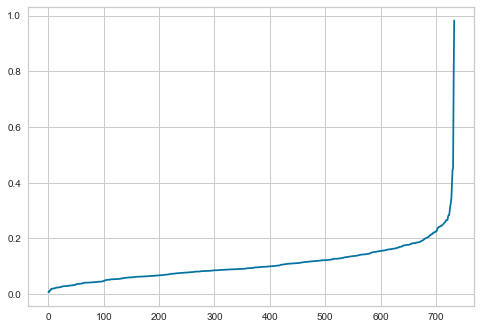

In [137]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(p=1)
nbrs = neigh.fit(minmax)
distances, indices = nbrs.kneighbors(minmax)

#Next, I sort and plot results.
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [138]:
from sklearn.cluster import DBSCAN
dbs = DBSCAN(eps=0.2, min_samples=5)
dbs = dbs.fit(minmax)

id_clusters = np.unique(dbs.labels_)
print('Found {} clusters'.format(len(id_clusters)))
np.unique(dbs.labels_, return_counts=True)

Found 3 clusters


(array([-1,  0,  1], dtype=int64), array([ 11, 343, 380], dtype=int64))

In [139]:
results_evaluation(dbs,minmax)

CLUSTERING DIVISION:
  1    380
 0    343
-1     11
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Domain Recurrence,Category importance
Cluster,,,,,,,,,,,
-1,142322.06,45069.90,37.43,80.84,89.99,1.75,301.65,1.24,71.73,55.04,38.43
0,133910.25,11042.79,9.23,69.37,81.59,1.45,55.07,0.46,61.58,49.87,4.20
1,152109.72,12999.39,10.12,76.71,86.64,1.54,89.28,0.62,68.66,65.24,58.61


The Silhouette Score is:  0.4764566211366614
The Calinski Harabasz Score is:  500.5323762469532
The Davies Douldin Score is:  2.021255015177075


- ### With Standard Scaler Data

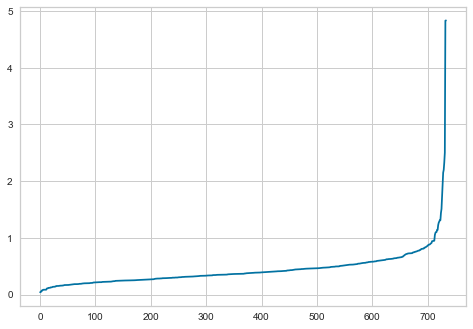

In [140]:
neigh = NearestNeighbors()
nbrs = neigh.fit(groupby_domains_StandardScaler)
distances, indices = nbrs.kneighbors(groupby_domains_StandardScaler)

#Next, I sort and plot results.
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [144]:
from sklearn.cluster import DBSCAN
dbs = DBSCAN(eps=1, min_samples=5)
dbs = dbs.fit(groupby_domains_StandardScaler)

id_clusters = np.unique(dbs.labels_)
print('Found {} clusters'.format(len(id_clusters)))
np.unique(dbs.labels_, return_counts=True)

Found 3 clusters


(array([-1,  0,  1], dtype=int64), array([ 41, 325, 368], dtype=int64))

In [145]:
results_evaluation(dbs, groupby_domains_StandardScaler )

CLUSTERING DIVISION:
  1    368
 0    325
-1     41
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Domain Recurrence,Category importance
Cluster,,,,,,,,,,,
-1,117004.66,26768.21,24.62,74.61,84.92,1.54,163.39,0.88,67.01,37.58,29.00
0,133159.38,10071.23,8.57,68.98,81.25,1.44,49.98,0.43,61.34,51.08,4.24
1,155501.26,13186.33,9.86,77.06,86.99,1.54,90.19,0.62,68.80,66.20,58.61


The Silhouette Score is:  0.2497554679228947
The Calinski Harabasz Score is:  120.14924483624911
The Davies Douldin Score is:  2.3715142494375443


- ### With Robust Scaler Data

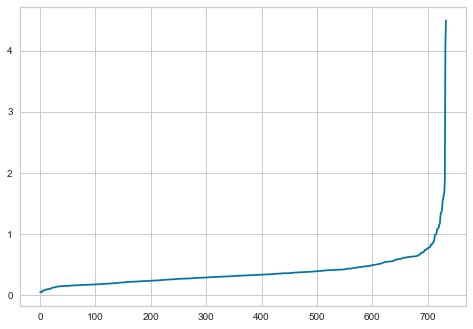

In [146]:
neigh = NearestNeighbors()
nbrs = neigh.fit(groupby_domains_RobustScaler)
distances, indices = nbrs.kneighbors(groupby_domains_RobustScaler)

#Next, I sort and plot results.
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [153]:
from sklearn.cluster import DBSCAN
dbs = DBSCAN(eps=0.8, min_samples=5)
dbs = dbs.fit(groupby_domains_RobustScaler)

id_clusters = np.unique(dbs.labels_)
print('Found {} clusters'.format(len(id_clusters)))
np.unique(dbs.labels_, return_counts=True)

Found 5 clusters


(array([-1,  0,  1,  2,  3], dtype=int64),
 array([ 49, 322, 356,   4,   3], dtype=int64))

In [154]:
results_evaluation(dbs, groupby_domains_RobustScaler )

CLUSTERING DIVISION:
  1    356
 0    322
-1     49
 2      4
 3      3
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Domain Recurrence,Category importance
Cluster,,,,,,,,,,,
-1,128814.68,28110.52,23.35,71.01,80.30,1.45,205.60,0.73,62.73,34.68,33.96
0,136247.88,10307.02,8.54,69.76,82.14,1.46,51.76,0.45,62.11,51.15,4.24
1,153843.69,12567.26,9.72,77.77,87.77,1.56,81.71,0.63,69.42,67.15,58.61
2,55986.56,1242.86,0.77,19.73,23.53,0.40,6.77,0.09,18.85,44.88,58.61
3,40804.59,16007.22,22.60,42.37,58.40,0.98,91.42,0.28,46.78,82.42,2.53


The Silhouette Score is:  0.06115553433414735
The Calinski Harabasz Score is:  32.849511608719745
The Davies Douldin Score is:  2.2813576853436355


## OPTICS

In [155]:
optics = OPTICS(min_samples=20).fit(minmax)

In [156]:
results_evaluation(optics,minmax)

CLUSTERING DIVISION:
  0    347
-1    330
 1     57
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Domain Recurrence,Category importance
Cluster,,,,,,,,,,,
-1,151255.50,13896.07,10.98,75.47,85.30,1.52,94.39,0.62,67.65,58.86,58.61
0,133946.63,11397.20,9.51,69.49,81.68,1.45,57.55,0.46,61.70,50.17,4.19
1,156222.05,11976.83,8.80,84.48,94.82,1.67,87.94,0.71,74.84,99.51,58.61


The Silhouette Score is:  0.2619138304816006
The Calinski Harabasz Score is:  573.3421703031726
The Davies Douldin Score is:  0.9198951949693125


## PCA + KMEANS

By reducing the number of features, we’re improving the performance of our algorithm. On top of that, by decreasing the number of features the noise is also reduced.
In the case of PCA and K-means in particular, there appears to be an even closer relationship between the two.

- **With the Robust Scaler data**

Text(0, 0.5, 'Cumulative explained variance')

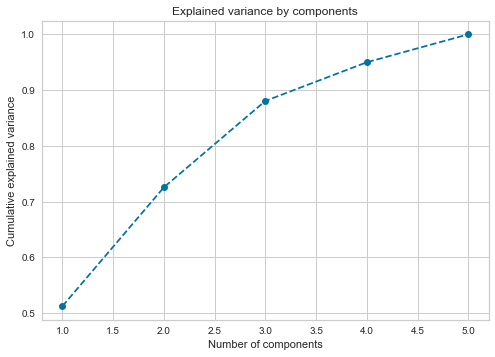

In [157]:
pca = PCA()
pca.fit(groupby_domains_RobustScaler)
plt.plot(range(1,6), pca.explained_variance_ratio_.cumsum(), marker= 'o' , linestyle = '--')
plt.title('Explained variance by components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

 A rule of thumb is to preserve around 80 % of the variance. So, in this instance, I decide to keep 4 components. I´ll perform PCA with the chosen number of components.

In [158]:
pca_robustscaler = PCA(n_components=3)
pca_robustscaler = pca_robustscaler.fit_transform(groupby_domains_RobustScaler)

C:\Users\Usuario\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\Usuario\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\Usuario\anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


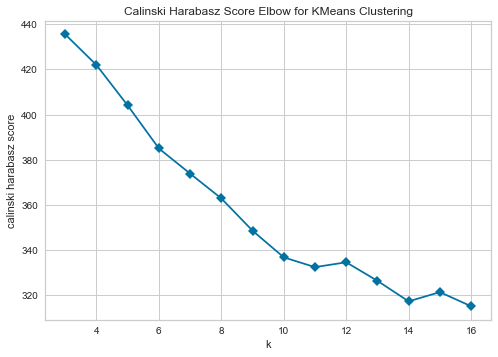

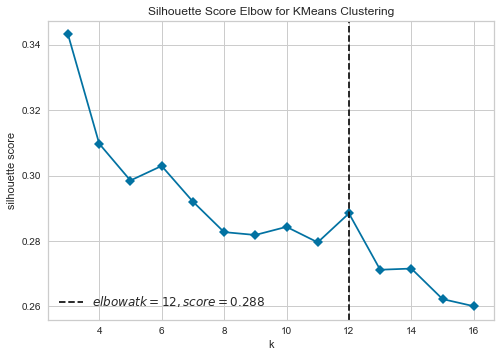

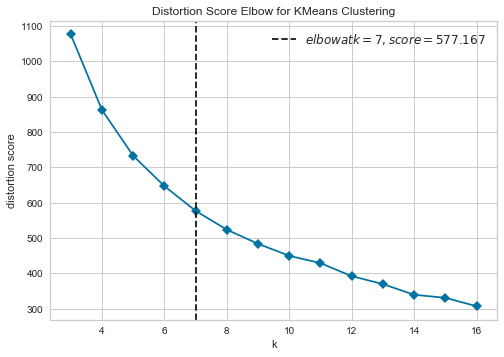

In [159]:
model = KMeans(init='k-means++', max_iter=1000, n_init=5, algorithm='auto')
visualization_clusters(pca_robustscaler, model)

- Initializing the KElbowVisualizer several times with the 3 kind of metrics (distortion, Silhouette and calinski_harabasz) the optimal number of clusters is between 5-7

In [163]:
kmeans_pca_robustscaler = KMeans(n_clusters=6, init='k-means++', max_iter=1000, n_init=5, algorithm='auto')
kmeans_pca_robustscaler.fit(pca_robustscaler)
results_evaluation(kmeans_pca_robustscaler, pca_robustscaler)

CLUSTERING DIVISION:
 3    184
2    156
5    143
0    139
1     82
4     30
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Domain Recurrence,Category importance
Cluster,,,,,,,,,,,
0,146525.87,22471.32,19.67,80.20,94.45,1.62,130.73,0.55,73.86,73.54,35.69
1,96239.83,5704.86,4.65,35.86,42.74,0.72,33.45,0.24,32.54,39.42,23.27
2,118529.06,6599.17,6.55,69.60,80.20,1.37,36.73,0.44,62.70,47.19,28.21
3,147212.01,10086.67,7.19,83.80,92.68,1.64,108.60,1.02,71.05,67.75,43.52
4,158851.44,57625.62,42.88,78.62,93.48,1.65,220.50,0.39,76.26,79.57,33.32
5,186689.53,7116.89,4.75,77.69,90.20,1.76,20.22,0.30,69.40,47.79,26.97


The Silhouette Score is:  0.3066232600984919
The Calinski Harabasz Score is:  385.0106223937391
The Davies Douldin Score is:  0.9516314220383638


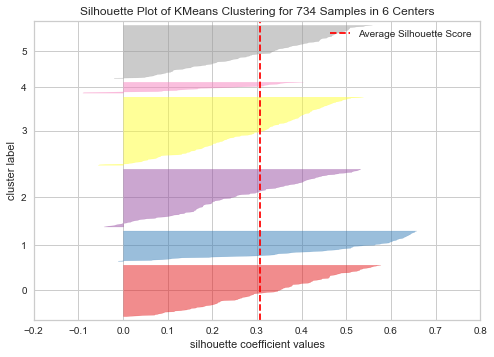

In [164]:
sv = SilhouetteVisualizer(kmeans_pca_robustscaler)
sv.fit(pca_robustscaler)
sv.show()

- **With the Standard Scaler Data**

Text(0, 0.5, 'Cumulative explained variance')

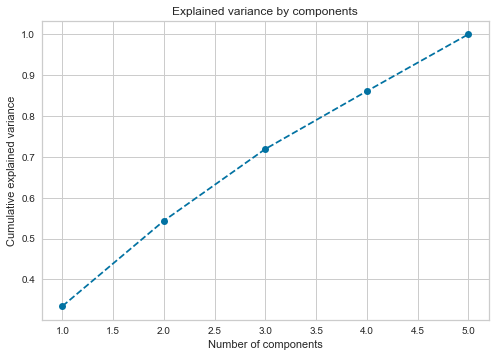

In [165]:
pca = PCA()
pca.fit(groupby_domains_StandardScaler)
plt.plot(range(1,6), pca.explained_variance_ratio_.cumsum(), marker= 'o' , linestyle = '--')
plt.title('Explained variance by components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

 A rule of thumb is to preserve around 80 % of the variance. So, in this instance, I decide to keep 4 components. I´ll perform PCA with the chosen number of components.

In [166]:
pca_standardscaler = PCA(n_components=4)
pca_standardscaler = pca_standardscaler.fit_transform(groupby_domains_StandardScaler)

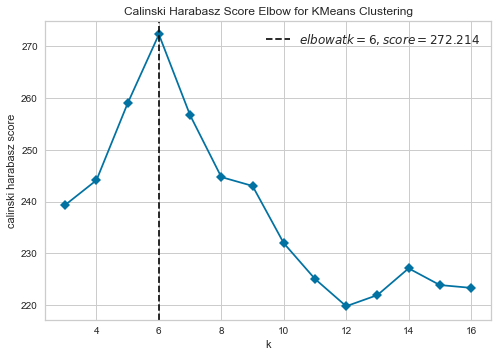

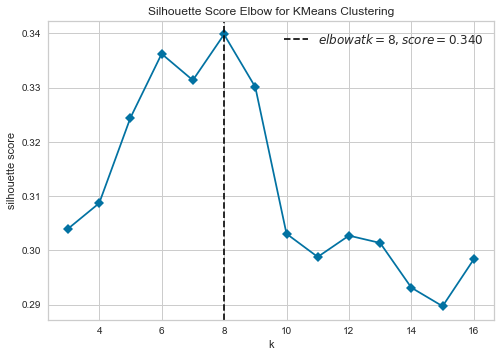

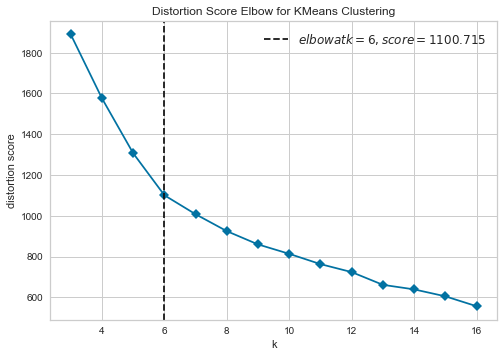

In [167]:
model = KMeans(init='k-means++', max_iter=1000, n_init=5, algorithm='elkan')
visualization_clusters(pca_standardscaler, model)

- Initializing the KElbowVisualizer several times with the 3 kind of metrics (distortion, Silhouette and calinski_harabasz) the optimal number of clusters is between 8-10

In [168]:
kmeans_pca_standardscaler = KMeans(n_clusters=6, init='k-means++', max_iter=1000, n_init=5, algorithm='elkan')
kmeans_pca_robustscaler.fit(pca_standardscaler)
results_evaluation(kmeans_pca_robustscaler, pca_standardscaler)

CLUSTERING DIVISION:
 5    197
4    142
0    135
1    126
3     77
2     57
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Domain Recurrence,Category importance
Cluster,,,,,,,,,,,
0,123315.82,10969.67,10.26,75.09,90.05,1.56,63.40,0.57,67.82,87.62,4.13
1,163428.77,8651.63,7.70,78.47,85.72,1.55,56.80,0.58,68.83,28.42,58.61
2,150383.93,43940.44,34.44,77.63,94.04,1.65,174.52,0.40,74.86,83.11,42.60
3,95839.59,5317.28,3.25,34.74,41.35,0.72,30.54,0.20,30.84,38.58,21.82
4,159707.11,8477.42,7.51,76.18,86.93,1.59,45.00,0.46,65.92,17.19,4.17
5,149385.02,12864.84,9.08,80.66,91.64,1.61,110.30,0.77,71.94,86.02,58.34


The Silhouette Score is:  0.3371816259427738
The Calinski Harabasz Score is:  272.2676673080688
The Davies Douldin Score is:  1.028271580413478


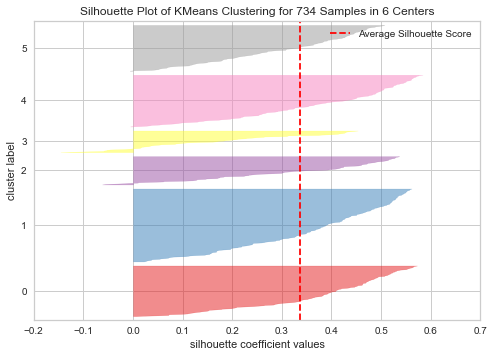

In [169]:
sv = SilhouetteVisualizer(kmeans_pca_standardscaler)
sv.fit(pca_standardscaler)
sv.show()

- **With the Minmax Scaler Data**

Text(0, 0.5, 'Cumulative explained variance')

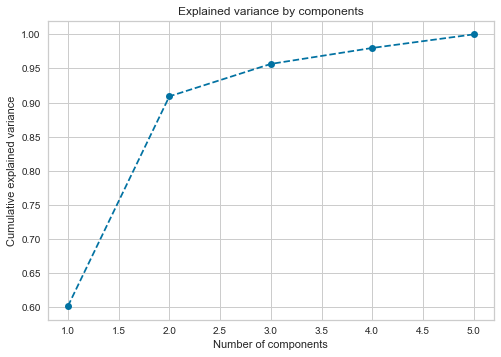

In [170]:
pca = PCA()
pca.fit(minmax)
plt.plot(range(1,6), pca.explained_variance_ratio_.cumsum(), marker= 'o' , linestyle = '--')
plt.title('Explained variance by components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

 A rule of thumb is to preserve around 80 % of the variance. So, in this instance, I decide to keep 4 components. I´ll perform PCA with the chosen number of components.

In [10]:
pca_minmax = PCA(n_components=2)
pca_minmax = pca_minmax.fit_transform(minmax)

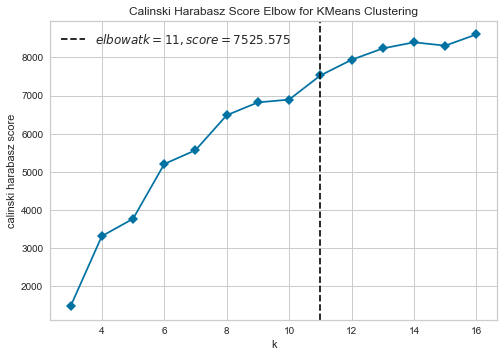

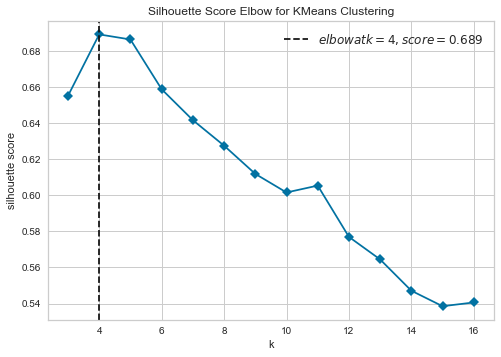

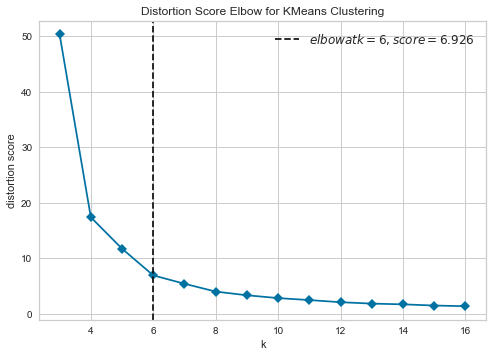

In [172]:
model = KMeans(init='k-means++', max_iter=1000, n_init=5, algorithm='elkan')
visualization_clusters(pca_minmax, model)

- Initializing the KElbowVisualizer several times with the 3 kind of metrics (distortion, Silhouette and calinski_harabasz) the optimal number of clusters is between 8-10

In [179]:
kmeans_pca_minmax = KMeans(n_clusters=5, init='k-means++', max_iter=1000, n_init=5, algorithm='elkan')
kmeans_pca_minmax.fit(pca_minmax)
results_evaluation(kmeans_pca_minmax, pca_minmax)

CLUSTERING DIVISION:
 0    190
1    182
2    157
4    110
3     95
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Domain Recurrence,Category importance
Cluster,,,,,,,,,,,
0,141658.90,8030.52,7.32,66.87,76.55,1.38,41.53,0.40,57.91,19.00,4.10
1,151545.53,17615.90,12.90,79.05,91.32,1.60,118.20,0.65,71.61,94.24,58.61
2,124613.31,15471.54,12.17,72.65,87.89,1.53,76.95,0.53,66.30,87.89,4.30
3,132947.37,7273.75,7.65,74.89,79.62,1.48,49.39,0.61,65.75,17.00,58.61
4,169160.77,12466.22,9.54,74.73,85.20,1.50,90.51,0.65,66.46,57.52,58.61


The Silhouette Score is:  0.6862236487158652
The Calinski Harabasz Score is:  3772.7000935674628
The Davies Douldin Score is:  0.4223936136002333


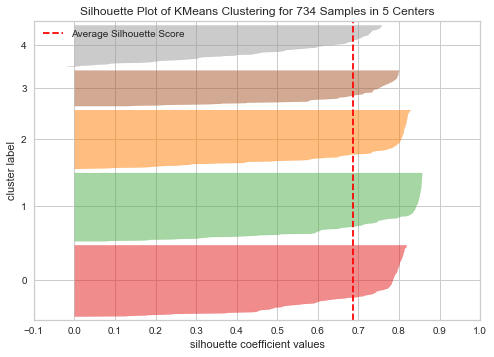

In [180]:
sv = SilhouetteVisualizer(kmeans_pca_minmax)
sv.fit(pca_minmax)
sv.show()

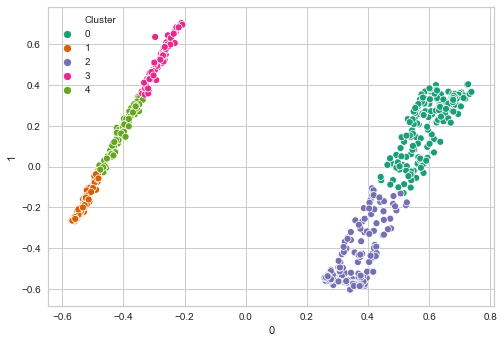

In [181]:
pca_minmax_df = pd.DataFrame(pca_minmax.copy())
pca_minmax_df['Cluster'] = kmeans_pca_minmax.labels_
sns.scatterplot(pca_minmax_df[0],pca_minmax_df[1],hue=pca_minmax_df['Cluster'], palette='Dark2')

- **With the orginal/raw Data**

Text(0, 0.5, 'Cumulative explained variance')

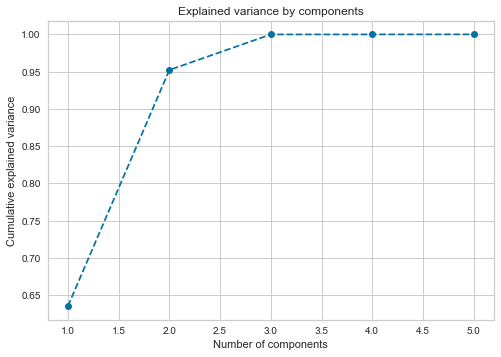

In [182]:
pca = PCA()
pca.fit(groupby_domains_clustering)
plt.plot(range(1,6), pca.explained_variance_ratio_.cumsum(), marker= 'o' , linestyle = '--')
plt.title('Explained variance by components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

 A rule of thumb is to preserve around 80 % of the variance. So, in this instance, I decide to keep 4 components. I´ll perform PCA with the chosen number of components.

In [183]:
pca_rawdata = PCA(n_components=2)
pca_rawdata = pca_rawdata.fit_transform(groupby_domains_clustering)

C:\Users\Usuario\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\Usuario\anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


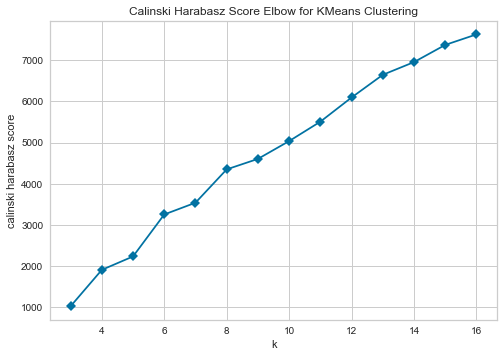

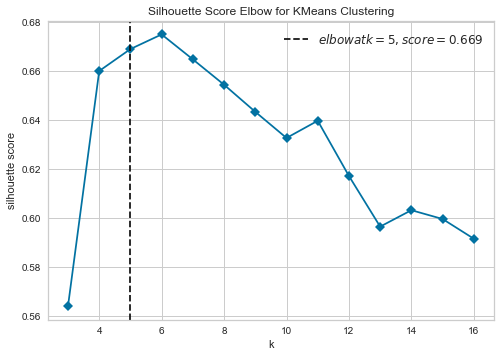

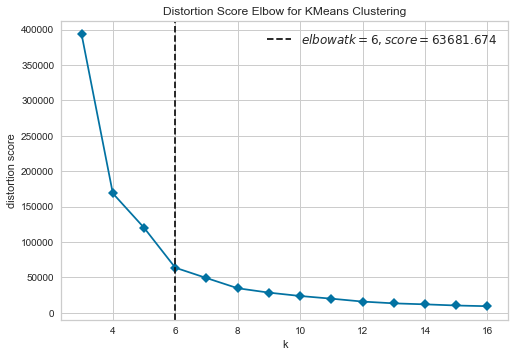

In [184]:
model = KMeans(init='k-means++', max_iter=1000, n_init=5, algorithm='auto')
visualization_clusters(pca_rawdata, model)

- Initializing the KElbowVisualizer several times with the 3 kind of metrics (distortion, Silhouette and calinski_harabasz) the optimal number of clusters is between 8-10

In [190]:
kmeans_pca_rawdata = KMeans(n_clusters=6, init='k-means++', max_iter=1000, n_init=5, algorithm='auto')
kmeans_pca_rawdata.fit(pca_rawdata)
results_evaluation(kmeans_pca_rawdata, pca_rawdata)

CLUSTERING DIVISION:
 2    184
3    138
0    129
5    110
1     93
4     80
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Domain Recurrence,Category importance
Cluster,,,,,,,,,,,
0,133524.33,17408.69,13.03,73.06,89.00,1.55,84.73,0.53,67.47,93.48,4.21
1,134794.98,7356.49,7.59,75.80,80.40,1.50,50.13,0.61,66.37,16.56,58.61
2,151119.48,17648.23,12.94,78.89,91.18,1.60,118.96,0.65,71.53,94.05,58.61
3,129833.48,6728.52,6.36,68.36,77.84,1.42,37.19,0.40,58.47,10.82,4.15
4,141722.79,9757.16,9.28,65.67,76.51,1.33,48.86,0.47,57.98,48.20,4.23
5,167973.23,12154.14,9.44,74.15,84.54,1.49,87.36,0.64,65.98,56.82,58.61


The Silhouette Score is:  0.674894303837993
The Calinski Harabasz Score is:  3253.672025680635
The Davies Douldin Score is:  0.4407723502612408


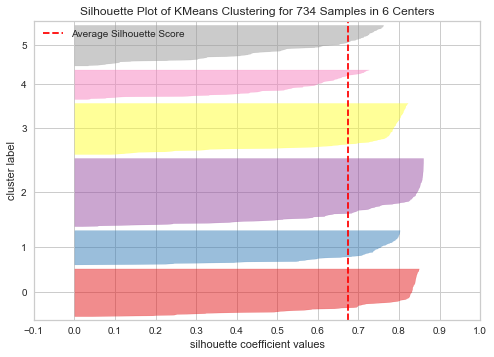

In [191]:
sv = SilhouetteVisualizer(kmeans_pca_rawdata)
sv.fit(pca_rawdata)
sv.show()

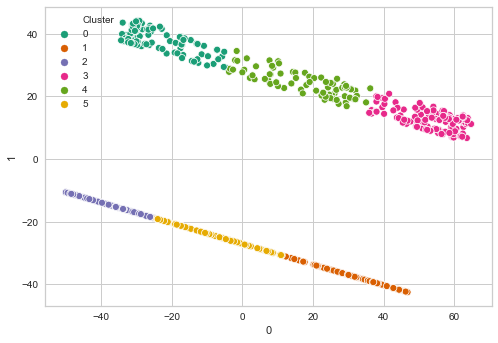

In [192]:
pca_rawdata_df = pd.DataFrame(pca_rawdata.copy())
pca_rawdata_df['Cluster'] = kmeans_pca_rawdata.labels_
sns.scatterplot(pca_rawdata_df[0],pca_rawdata_df[1],hue=pca_rawdata_df['Cluster'], palette='Dark2')

- ### Conclussions:

K-Means + PCA transformation with the Minmax Scaler data gives a significant better result than the K-Means algorithm without PCA. The Silhouette Score with 8 cluster is about 90%.

## K-MEDOIDS

- ### With the Robust Scaler Data

In [197]:
%run KMEDOIDS.py

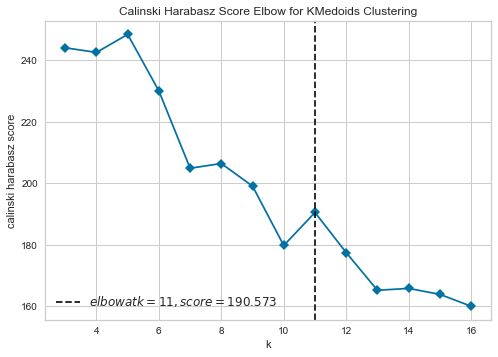

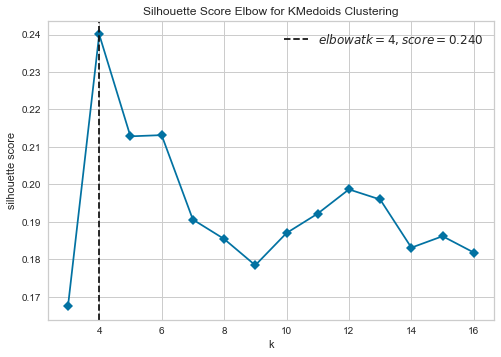

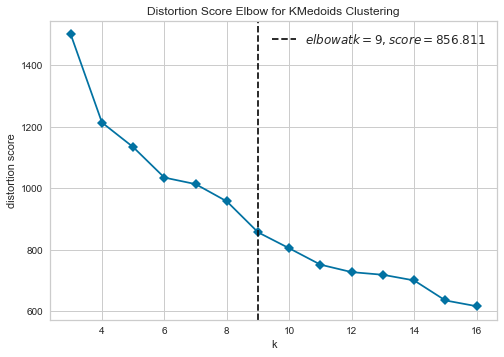

In [200]:
# Instantiate the clustering model and visualizer
model = KMedoids(init= 'k-medoids++')

visualization_clusters(groupby_domains_RobustScaler,model)

In [201]:
kmedoids_robust = KMedoids(n_clusters = 4, init= 'k-medoids++')
kmedoids_robust.fit(groupby_domains_RobustScaler)
results_evaluation(kmedoids_robust, groupby_domains_RobustScaler )

CLUSTERING DIVISION:
 1    258
0    227
3    150
2     99
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Domain Recurrence,Category importance
Cluster,,,,,,,,,,,
0,156458.20,7637.38,5.71,74.98,88.02,1.62,26.70,0.33,67.11,49.00,15.57
1,147588.68,8700.20,7.20,81.69,90.57,1.60,81.47,0.89,70.44,63.05,47.50
2,100512.90,5744.39,4.86,39.15,46.49,0.79,34.19,0.27,35.28,42.32,23.87
3,145025.24,31174.55,25.28,79.07,92.99,1.60,171.12,0.51,74.02,72.81,39.89


The Silhouette Score is:  0.23103684246864117
The Calinski Harabasz Score is:  293.4789718755578
The Davies Douldin Score is:  1.373464635462096


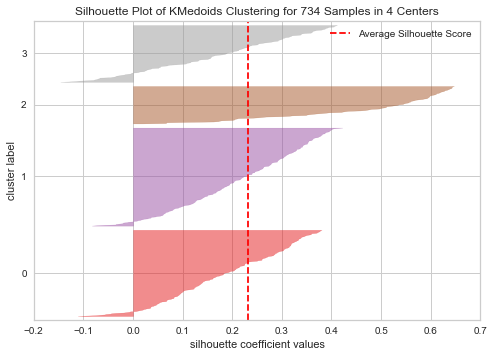

In [202]:
sv = SilhouetteVisualizer(kmedoids_robust)
sv.fit(groupby_domains_RobustScaler)
sv.show()

- ### With the Standard Scaler Data

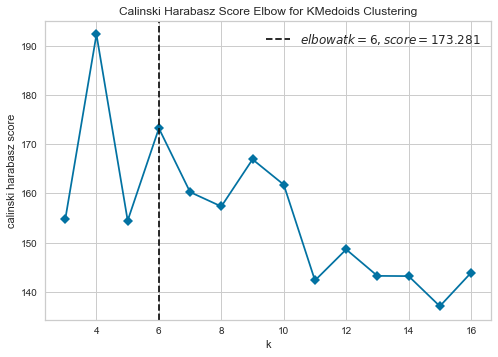

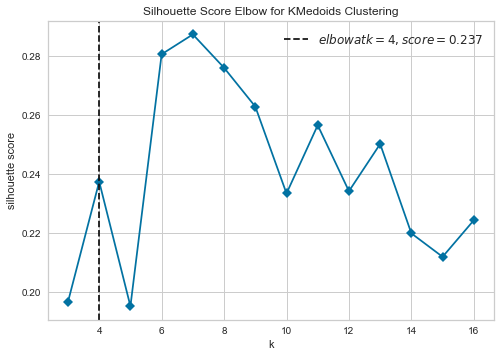

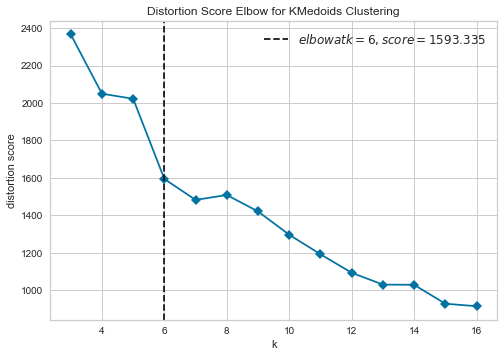

In [207]:
# Instantiate the clustering model and visualizer
model = KMedoids(init= 'k-medoids++')
visualization_clusters(groupby_domains_StandardScaler,model)

In [208]:
kmedoids_standard = KMedoids(n_clusters = 6, init= 'k-medoids++')
kmedoids_standard.fit(groupby_domains_StandardScaler)
results_evaluation(kmedoids_standard, groupby_domains_StandardScaler )

CLUSTERING DIVISION:
 1    212
3    162
4    155
0     75
2     69
5     61
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Domain Recurrence,Category importance
Cluster,,,,,,,,,,,
0,134749.27,10224.30,7.89,66.91,84.02,1.50,39.30,0.30,62.67,83.39,3.98
1,153835.05,14811.51,10.53,80.59,92.28,1.62,114.17,0.73,72.28,87.41,58.61
2,119904.01,10922.86,9.63,81.48,93.20,1.61,107.82,1.01,69.57,78.32,4.92
3,140744.81,5384.35,5.06,64.06,73.47,1.34,23.74,0.34,55.12,17.24,4.22
4,152079.06,8345.27,6.93,71.34,78.43,1.42,52.22,0.51,63.11,32.76,58.61
5,130048.14,39293.30,33.48,76.61,90.90,1.56,157.40,0.40,73.22,72.83,21.39


The Silhouette Score is:  0.21800502100596408
The Calinski Harabasz Score is:  147.4789915264274
The Davies Douldin Score is:  1.3875524344757313


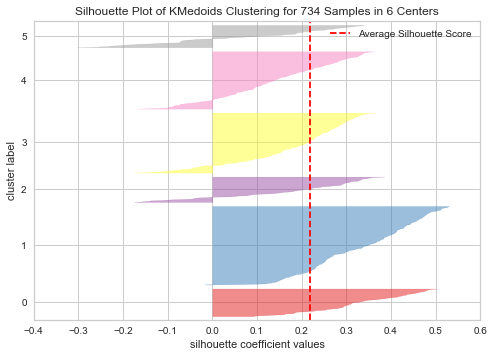

In [209]:
sv = SilhouetteVisualizer(kmedoids_standard)
sv.fit(groupby_domains_StandardScaler)
sv.show()

- ### With the MinMax Scaler Data

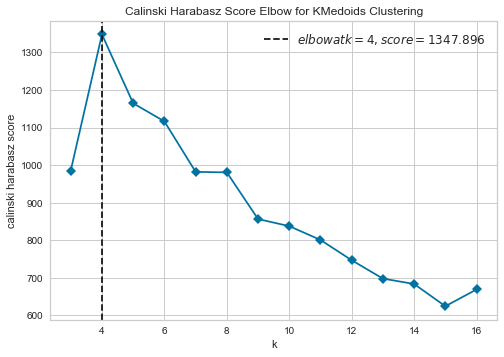

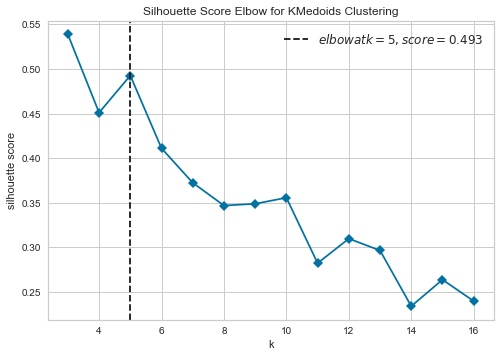

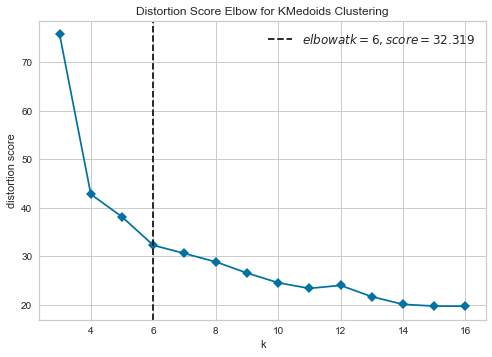

In [210]:
# Instantiate the clustering model and visualizer
model = KMedoids(init= 'k-medoids++')
visualization_clusters(minmax,model)

In [213]:
kmedoids_minmax = KMedoids(n_clusters = 4, init= 'k-medoids++')
kmedoids_minmax.fit(minmax)
results_evaluation(kmedoids_minmax, minmax )

CLUSTERING DIVISION:
 2    216
1    192
0    171
3    155
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Domain Recurrence,Category importance
Cluster,,,,,,,,,,,
0,156580.55,10356.17,8.98,75.43,82.51,1.49,70.48,0.63,66.35,32.27,58.61
1,140876.26,8022.02,7.37,67.03,76.73,1.39,41.73,0.41,58.01,19.35,4.11
2,148350.45,16192.03,11.98,77.89,90.03,1.58,111.62,0.64,70.58,90.63,58.61
3,125362.84,15578.08,12.17,72.53,87.81,1.52,77.16,0.53,66.27,88.34,4.29


The Silhouette Score is:  0.5284042389956622
The Calinski Harabasz Score is:  1345.7093323155293
The Davies Douldin Score is:  0.6933206382745569


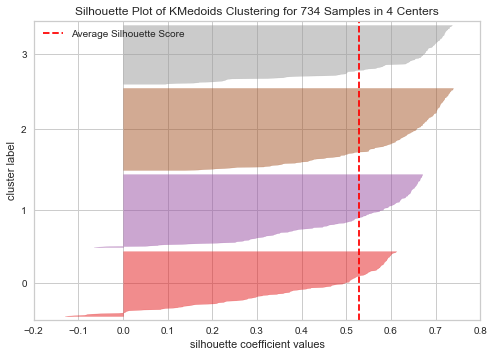

In [214]:
sv = SilhouetteVisualizer(kmedoids_minmax)
sv.fit(minmax)
sv.show()

- ### With the Raw Data

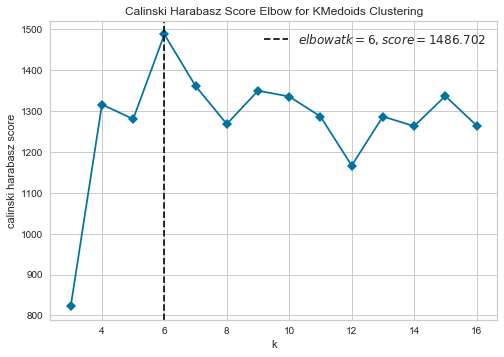

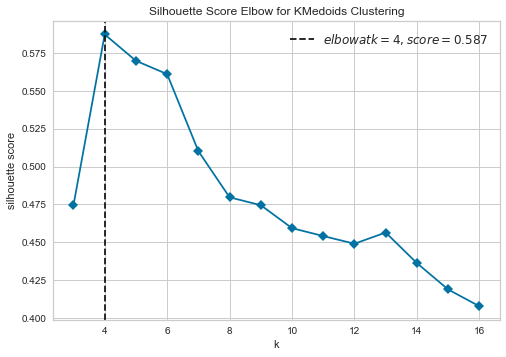

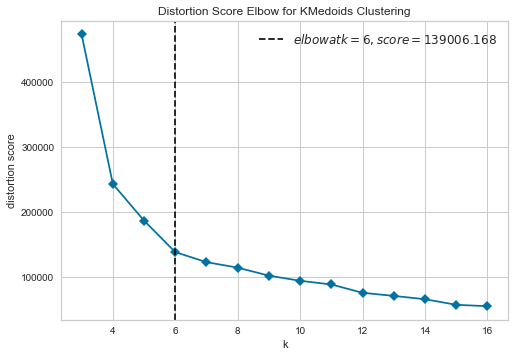

In [215]:
# Instantiate the clustering model and visualizer
model = KMedoids(init= 'k-medoids++')
visualization_clusters(groupby_domains_clustering,model)

In [219]:
kmedoids_raw = KMedoids(n_clusters = 5, init= 'k-medoids++')
kmedoids_raw.fit(groupby_domains_clustering)
results_evaluation(kmedoids_raw, groupby_domains_clustering )

CLUSTERING DIVISION:
 0    225
3    162
1    134
2    128
4     85
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Domain Recurrence,Category importance
Cluster,,,,,,,,,,,
0,146895.67,15776.97,11.70,77.54,89.59,1.57,109.15,0.65,70.31,89.48,58.61
1,126623.41,6821.64,6.50,68.67,78.29,1.43,38.21,0.41,58.58,10.29,4.10
2,133371.83,17432.03,13.01,73.09,88.98,1.55,84.87,0.53,67.41,93.65,4.19
3,159058.31,10608.42,9.20,75.77,82.70,1.50,71.63,0.62,66.49,30.62,58.61
4,146357.05,9522.71,8.99,65.36,76.06,1.34,46.92,0.45,58.04,47.56,4.33


The Silhouette Score is:  0.5676331949529552
The Calinski Harabasz Score is:  1279.9624723430638
The Davies Douldin Score is:  0.5983591054733969


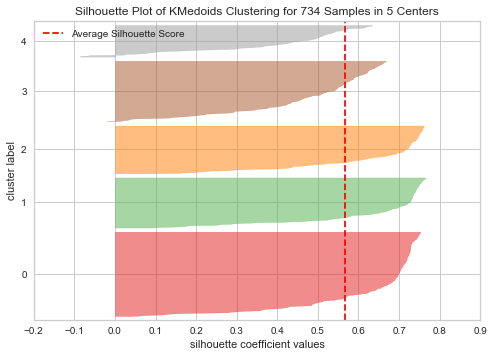

In [220]:
sv = SilhouetteVisualizer(kmedoids_raw)
sv.fit(groupby_domains_clustering)
sv.show()

- **With the PCA scores**

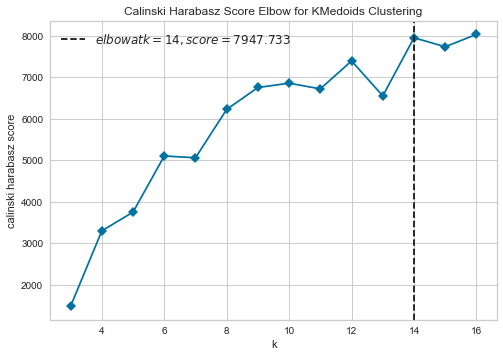

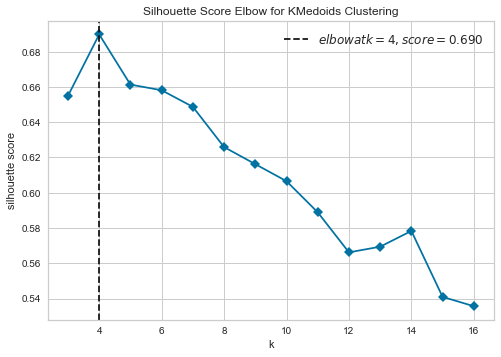

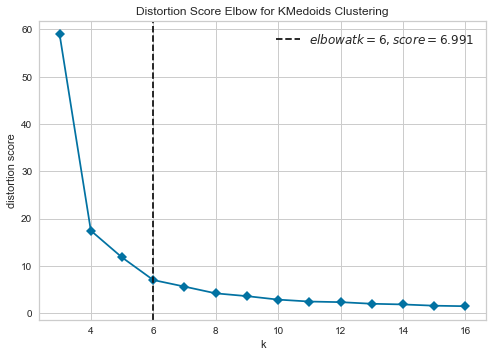

In [221]:
# Instantiate the clustering model and visualizer
model = KMedoids(init= 'k-medoids++')
visualization_clusters(pca_minmax,model)

In [222]:
kmedoids_pca_minmax = KMedoids(n_clusters = 5, init= 'k-medoids++')
kmedoids_pca_minmax.fit(pca_minmax)
results_evaluation(kmedoids_pca_minmax, pca_minmax )

CLUSTERING DIVISION:
 1    193
0    177
3    154
4    115
2     95
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Domain Recurrence,Category importance
Cluster,,,,,,,,,,,
0,153691.81,17958.87,12.86,78.82,91.23,1.60,120.38,0.64,71.51,94.74,58.61
1,140395.95,7983.74,7.34,66.99,76.70,1.39,41.55,0.41,57.97,19.54,4.13
2,132947.37,7273.75,7.65,74.89,79.62,1.48,49.39,0.61,65.75,17.00,58.61
3,125864.04,15675.12,12.24,72.61,87.93,1.53,77.62,0.53,66.38,88.55,4.27
4,165091.49,12162.24,9.75,75.27,85.60,1.51,88.36,0.66,66.84,58.34,58.61


The Silhouette Score is:  0.6850908912177546
The Calinski Harabasz Score is:  3750.16985356502
The Davies Douldin Score is:  0.42380238233701906


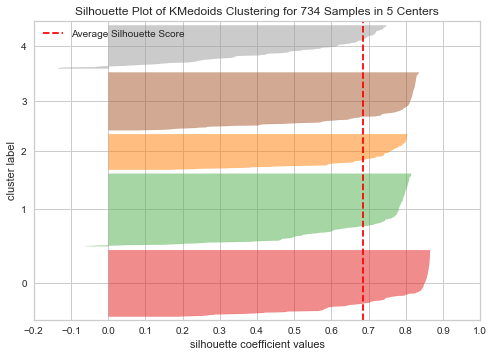

In [223]:
sv = SilhouetteVisualizer(kmedoids_pca_minmax)
sv.fit(pca_minmax)
sv.show()

# *TESTS RESULTS*

In [95]:
tests_results = pd.read_csv('RESULTS CLUSTERING TESTS.csv')

In [96]:
tests_results.sort_values(by= 'SILHOUETTE SCORE', ascending =False).head(5)

,DATA TRANSFORMATION,ALGORITHM,NºCLUSTERS,SILHOUETTE SCORE,CALINSKI HARABASZ SCORE
10,MMS,PCA+KMEANS,4,70,3778
16,MMS,KMEDOID + PCA,4,69,3636
11,RAW,PCA+KMEANS,6,66,3228
15,RAW,KMEDOIDS,4,53,892
2,MMS,KMEANS,4,"50,28",1205


- ***I´ll work with the clustering with the best Silhouette score and Calinski Harabasz Score***

In [15]:
kmeans_pca_minmax = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=5, algorithm='auto')
kmeans_pca_minmax.fit(pca_minmax)
results_evaluation(kmeans_pca_minmax, pca_minmax)

CLUSTERING DIVISION:
 0    224
1    190
2    163
3    157
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Domain Recurrence,Category importance
Cluster,,,,,,,,,,,
0,147406.59,15838.06,11.75,77.79,89.88,1.58,109.58,0.65,70.54,89.61,58.61
1,141658.90,8030.52,7.32,66.87,76.55,1.38,41.53,0.40,57.91,19.00,4.10
2,158281.56,10556.18,9.16,75.43,82.35,1.49,71.26,0.62,66.20,30.81,58.61
3,124613.31,15471.54,12.17,72.65,87.89,1.53,76.95,0.53,66.30,87.89,4.30


The Silhouette Score is:  0.6889868812670192
The Calinski Harabasz Score is:  3319.0101986376667
The Davies Douldin Score is:  0.4291506624342666


## CLUSTER ANALYSIS

In [266]:
clusters = groupby_domains_clustering.copy()
clusters['Cluster'] = kmeans_pca_minmax.labels_
clusters['Cluster'] = clusters['Cluster'] + 1
cluster1 = clusters[clusters['Cluster']==1]
cluster2 = clusters[clusters['Cluster']==2]
cluster3 = clusters[clusters['Cluster']==3]
cluster4 = clusters[clusters['Cluster']==4]


clusters.groupby('Cluster').mean()

clusters.to_csv('Main Clusters before subclustering.csv', index=False)

In [26]:
clusters = pd.read_csv('Main Clusters before subclustering.csv')

In [273]:
display(cluster1.describe(),cluster2.describe(), cluster3.describe(), cluster4.describe()) 



,Format Fill Rate,CPM,CTR,Domain Recurrence,Category importance,Cluster
count,224.00,224.00,224.00,224.00,224.00,224.00
mean,11.75,1.58,0.65,89.61,58.61,1.00
std,10.15,0.23,0.33,11.91,0.00,0.00
min,0.29,0.66,0.03,60.66,58.61,1.00
25%,4.24,1.55,0.40,81.15,58.61,1.00
50%,8.66,1.64,0.64,94.81,58.61,1.00
75%,16.30,1.71,0.83,100.00,58.61,1.00
max,63.20,2.18,1.58,100.00,58.61,1.00


,Format Fill Rate,CPM,CTR,Domain Recurrence,Category importance,Cluster
count,190.00,190.00,190.00,190.00,190.00,190.00
mean,7.32,1.38,0.40,19.00,4.10,2.00
std,8.48,0.45,0.38,15.22,2.42,0.00
min,0.00,0.00,0.00,0.27,0.07,2.00
25%,1.40,1.21,0.12,6.63,1.98,2.00
50%,4.04,1.51,0.30,13.11,3.57,2.00
75%,9.52,1.67,0.55,33.27,6.61,2.00
max,43.62,2.38,1.81,53.28,7.63,2.00


,Format Fill Rate,CPM,CTR,Domain Recurrence,Category importance,Cluster
count,163.00,163.00,163.00,163.00,163.00,163.00
mean,9.16,1.49,0.62,30.81,58.61,3.00
std,11.84,0.36,0.46,18.52,0.00,0.00
min,0.01,0.30,0.00,0.55,58.61,3.00
25%,1.69,1.44,0.31,14.21,58.61,3.00
50%,6.15,1.56,0.55,28.14,58.61,3.00
75%,12.61,1.65,0.86,48.63,58.61,3.00
max,112.28,2.53,3.86,61.20,58.61,3.00


,Format Fill Rate,CPM,CTR,Domain Recurrence,Category importance,Cluster
count,157.00,157.00,157.00,157.00,157.00,157.00
mean,12.17,1.53,0.53,87.89,4.30,4.00
std,10.56,0.25,0.34,14.60,2.52,0.00
min,0.10,0.54,0.01,52.73,0.07,4.00
25%,4.85,1.49,0.30,76.50,1.98,4.00
50%,9.12,1.60,0.47,95.63,4.76,4.00
75%,16.96,1.68,0.74,100.00,6.61,4.00
max,67.94,1.94,2.20,100.00,7.63,4.00


**CLUSTER 1**: 190 domains. Is the least recurrent cluster, 72% of the domains have less than 30% of recurrence, and the maximun is 53%. The domains belong to all the minority categories, especially Sports and Tech Gaming, which represents aroun 40% of these domains.  This cluster is also the one with the lowest Format Fill rate. 

**CLUSTER 2**: 224 domains. The Domains are also very recurrent, more than in the Cluster 1,  70% of the domains have a recurrence beyond 80%, and 35% have a recurrence of 100%. All the domains belongs to the News & Portals category. The Format Fill Rate is low, only 11 domains have a format fill rate beyond 30%

**CLUSTER 3**: 157 Domains. The Domains are really recurrent, more than 70% of the domains have a recurrence beyond 80%,  and the minimun value is 52%. The domains belong to all the minority categories, especially Community&Culture, Sports and Tech&Gaming.

**CLUSTER 4**: 163 domains. The Domains are no recurrent, the mean is 30.81% and 77% of them are below than 50% of recurrence.All the domains belongs to the News & Portals category. 


**We can see in this first clustering that the decisive variables have been the Category importance and the Domain recurrence.**
- Cluster1 and Cluster2 have high recurrence but the difference is that in the Cluster2 we only have the News&Portals category, and in Cluster4 we have the rest of the categories
- Cluster3 and Cluster4 have low recurrence but the difference is the same: in the cluster3 all the domains are from the News&Portal Category.

**NOTE**: ***Some of the clustering algorithms generated an slightly better result with k=5 or k=6, but I decide to keep k=4 beacuse it has more "business sense", we can markedly appreciate the differences between clusters***